# This is a practice notebook for pytorch on image (MNIST)

We implemented 4 models:
* DNN
* CNN
* LSTM
* Bidirectional LSTM

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import SGD,Adam
import torch.nn.functional as F

In [2]:
seed = 1234
torch.manual_seed(seed)
torch.device("cpu");
#torch.device("cuda")

### Download and transform dataset (MNIST)

In [3]:
## Define the transform function
## Convert images to number that understand by pytorch
## Separates into 3 colours (RGB)
## Converts each pixel to the brightness of its colour (0-255)
## Scale the values to a range between 0 and 1

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [5]:
## Download dataset and transfrom

trainset = datasets.MNIST('../Datasets/MNIST/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('../Datasets/MNIST/val', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### EDA

In [5]:
## Load train data
dataiter = iter(trainloader)
images, labels = dataiter.next()

## Print shapes of train data (64 images in EACH BATCH and each images has 28x28 pixels)
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


tensor(1)


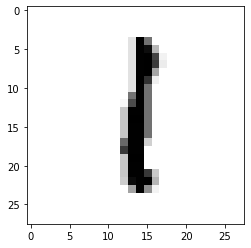

In [32]:
## Print first image

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
print(labels[0])

# MODELS

### Deep Neural Network class

In [17]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN,self).__init__()
        
        ## Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784,128)
        ## Fc layer 2
        self.fc2 = nn.Linear(128,64)
        ## Output layer, 10 unites - one for each digit
        self.output = nn.Linear(64,10)
        
    def forward(self, x):
        
        ## Pass the input tensor through each operations
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.log_softmax(x,dim=1)
        return(x)
    
model = DNN()
print(model)

DNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)


### Convolutional Neural Network class

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(9216,128)
        self.fc2 = nn.Linear(128,10)

        
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x,2)
        x = torch.flatten(x,start_dim = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return(x)

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Long-short Term Memory class

In [77]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM,self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=28, 
                             hidden_size=64, 
                             num_layers=2,
                             batch_first=True) #input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        self.lstm2 = nn.LSTM(input_size=64,
                             hidden_size=32,
                             num_layers=1,
                             batch_first=True)
        self.fc1 = nn.Linear(32,10)
        
    def forward(self,x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)  -- hidden layer
        # h_c shape (n_layers, batch, hidden_size)  -- cell state
        # None represents zero initial hidden state
        
        r_out, (h_n, h_c) = self.lstm1(x,None)
        r_out, (h_n, h_c) = self.lstm2(r_out, None)
        
        x = self.fc1(r_out[:,-1,:])
        return(x)

model = LSTM()
print(model)

LSTM(
  (lstm1): LSTM(28, 64, num_layers=2, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=10, bias=True)
)


### Bidirectional Long-short Term Memory

In [82]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM,self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=28,
                             hidden_size=64,
                             num_layers=2,
                             batch_first=True,
                             bidirectional=True)
        self.fc1 = nn.Linear(64*2,10)   ## 2 for bidirectional
    
    def forward(self,x):
        
        r_out, (h_n, h_c) = self.lstm1(x,None)
        x = self.fc1(r_out[:,-1,:])
        return(x)

model = BiLSTM()
print(model)

BiLSTM(
  (lstm1): LSTM(28, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


# TRAIN & TEST

### Training & Testing for LSTM (RNN)

In [83]:
############### TRAINING for LSTM

## Define optimizer
optimizer = SGD(model.parameters(), lr = 0.01, momentum = 0.5)
#optimizer = Adam(model.parameters(), lr = 0.01)

## Define loss function
criterion = nn.CrossEntropyLoss()

## Training starts here
epochs = 5
for e in range(epochs):
    running_loss = 0
    timer = time.time()
    for step,(x,y) in enumerate(trainloader):

        ## reshape images to (batch, time_step, input_size)(LSTM)
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y
        
        ## For each iteration reset gradient
        optimizer.zero_grad()
        
        ## Run the input data through the network (forward pass)
        output = model(b_x)
        
        ## Calculate the losses using the loss functioon
        loss = criterion(output, b_y)
        
        ## Perform backpropagation 
        loss.backward()
        
        ## Updates the weights
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        print("Epoch {} - Training loss: {:.6f} - Time: {:.4f}s".format(e+1, running_loss/len(trainloader), (time.time()-timer)))

Epoch 1 - Training loss: 2.300307 - Time: 47.8980s
Epoch 2 - Training loss: 2.292306 - Time: 48.4485s
Epoch 3 - Training loss: 2.157634 - Time: 48.6506s
Epoch 4 - Training loss: 1.239763 - Time: 46.7079s
Epoch 5 - Training loss: 0.454633 - Time: 48.6574s


In [84]:
################### TESTING for LSTM

all_labels = []
probs = pd.Series([0])

with torch.no_grad():
    for step, (x,y) in enumerate(valloader):
        ## reshape images to (batch, time_step, input_size)(LSTM)
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output_test = model(b_x)
        output_test = torch.exp(output_test)
        output_test = output_test.tolist()
        output_test = pd.Series(output_test)
        probs = probs.append(output_test,ignore_index=True)
        all_labels += b_y.tolist()

def getClass(x):
    return(x.index(max(x)))

all_predicted = probs[1:].apply(getClass)
all_predicted.reset_index(drop=True, inplace=True)

### Training function (DNN,CNN)

In [ ]:
## Define optimizer
optimizer = SGD(model.parameters(), lr = 0.01, momentum = 0.5)
#optimizer = Adam(model.parameters(), lr = 0.01)

## Define loss function
criterion = nn.NLLLoss()

## Training starts here
epochs = 15
for e in range(epochs):
    running_loss = 0
    timer = time.time()
    for images, labels in trainloader:
        
        ## Flatten the images into 784 long vector (DNN)
        #images = images.view(images.shape[0], -1)

        ## For each iteration reset gradient
        optimizer.zero_grad()
        
        ## Run the input data through the network (forward pass)
        output = model(images)
        
        ## Calculate the losses using the loss functioon
        loss = criterion(output, labels)
        
        ## Perform backpropagation 
        loss.backward()
        
        ## Updates the weights
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        print("Epoch {} - Training loss: {:.6f} - Time: {:.4f}s".format(e+1, running_loss/len(trainloader), (time.time()-timer)))

### Testing (DNN,CNN)

In [40]:
all_labels = []
probs = pd.Series([0])

with torch.no_grad():
    for images, labels in valloader:
            
            # For DNN
            #images = images.view(images.shape[0], -1)
            
            output_test = model(images)
            output_test = torch.exp(output_test)
            output_test = output_test.tolist()
            output_test = pd.Series(output_test)
            probs = probs.append(output_test,ignore_index=True)
            all_labels += labels.tolist()

def getClass(x):
    return(x.index(max(x)))

all_predicted = probs[1:].apply(getClass)
all_predicted.reset_index(drop=True, inplace=True)

### Evaluation (ALL models)

In [85]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix

acc = (pd.value_counts(all_predicted == all_labels)[1])/len(all_labels)
print('Testing accuracy: ', acc)
print()

confusion = sklearn.metrics.confusion_matrix(y_true=all_labels, y_pred=all_predicted)
print(confusion)

Testing accuracy:  0.9206

[[ 945    0    7    2    1   10    3    1   11    0]
 [   0 1119    8    1    0    4    0    0    2    1]
 [   6    2  970   36    0   11    0    6    0    1]
 [   0    1   30  904    0   39    0   28    1    7]
 [   0    0    4    0  852    3   14    2    5  102]
 [   4    2    7   43    1  808    0    7    6   14]
 [  20    4   13    0   12   42  854    0   13    0]
 [   0    9   10   15    3    6    0  956    0   29]
 [  24    4    4   11    1   52    3    0  867    8]
 [   1    1    0    3   17   25    0   29    2  931]]
